# Numerical computation of manifolds
The objective of this notebook is to explain a way to numerically calculate the tube manifolds of a vertical Lyapunov orbit around a Lagrange point.
The main idea is to introduce a Poincaré section and treat the periodic orbit as a fixed point on this section.

The main steps are:
1. Test the integrator
2. Study the linearization around an equilibrium point
3. Find an approximation of periodic orbit from the linearization
4. Use the approximation as the initial guess of a root finding algorithm
5. Find the actual periodic orbit
6. Find the tube manifolds of the periodic orbit

The theoretical details are glossed over, however one can find a more extensive explaination of the mathematics behind our process in the document "Numerical calculation of manifolds of periodic orbits of the restricted three body problem".

In [2]:
import phase as ph
import poincare as pn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Initialize the problem. We choose the Earth-Moon system, therefore the massa parameter is $\mu = 0.01215$. 
First of all we test the integrator to check that our Hamilton equations are correct. Since the system is subject to the gravitational forces of the two bodies one can expect the energy to be constant (or nearly so because of numerical errors).

## 1. Test integrator

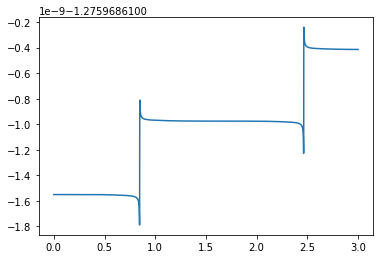

In [3]:
m = .01215
ci = np.array([.8,0,0,-.01,0,.1])
sol = solve_ivp(ph.ham_eqs,[0,3],ci,args=(m,),atol=1e-12,rtol=1e-11)
E_test = ph.energy(sol.y,m)
plt.plot(sol.t,E_test)

The result has an error of magnitude $10^{-9}$, which is small enough for our purposes

We want to study the Hamiltonian flow close to a equilibrium point. We search for the collinear Lagrange points. The function
```
lagrange_coll()
```
finds the x-coordinate of these points.

## 2. Linearization

In [4]:
L_points = ph.lagrange_coll(m)

We choose the equilibrium point of the phase space $L_1$. Now we want to study the linearized system around this equilibrium point. We calculate the Jacobian $ /nabla f(r)$ in $L_1$ and study its eigenvalues $\lambda$ and its eigenvectors $V$.

In [7]:
L1 = L_points[0]
p_eq = np.array([L1,0,0,0,L1,0])
dF = ph.jacobian(p_eq,m)
dFD,dFV = np.linalg.eig(J)
print(dFD)
print('------------------------------------------------------------------')
print(dFV)

[-2.93204868e+00+0.j          2.93204868e+00+0.j
  1.11022302e-16+2.33438132j  1.11022302e-16-2.33438132j
  0.00000000e+00+2.26882643j  0.00000000e+00-2.26882643j]
------------------------------------------------------------------
[[ 2.79067715e-01+0.00000000e+00j  2.79067715e-01+0.00000000e+00j
  -1.19710564e-01-3.89595415e-17j -1.19710564e-01+3.89595415e-17j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00-0.00000000e+00j]
 [ 1.28406957e-01+0.00000000e+00j -1.28406957e-01+0.00000000e+00j
   2.65601095e-17-4.29341057e-01j  2.65601095e-17+4.29341057e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00-0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00-0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00-4.03318497e-01j  0.00000000e+00+4.03318497e-01j]
 [-9.46647083e-01+0.00000000e+00j  9.46647083e-01+0.00000000e+00j
  -8.31661309e-17+1.49890953e-01j -8.31661309e-17-1.49890953e-01j
   0.00000000e+00+0.00000000e+00j  0.000

We notice that the eigenvalues $\lambda_1 < 0$ and $\lambda_2 > 0$, therefore their eigenvectors span the stable and unstable linearized spaces.
We need a point on the center space that lies on the $z=0$ plane to implement our root finding algorithm.
Following $\delta r = V \cdot u$:

In [8]:
u = 1e-3*np.array([0,0,0,0,1,1])
r0 = p_eq + np.real(dFV@u)

$r_0$ is the initial approximation of the periodic orbit.

## 3. Orbit approximation

Visualize the approximate orbit derived from the linearization.

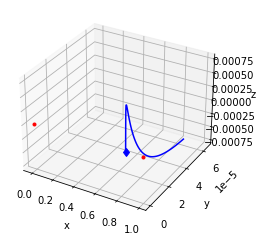

In [9]:
sol = solve_ivp(ph.ham_eqs,[0,2],r0,args=(m,),atol=1e-13,rtol=1e-12)
fig = plt.figure(1)
ax1 = plt.axes(projection='3d')
ax1.plot(sol.y[0,:],sol.y[1,:],sol.y[2,:],'b')
ax1.plot(sol.y[0,0],sol.y[1,0],sol.y[2,0],'db')
ax1.plot(1-m,0,0,'.r')
ax1.plot(-m,0,0,'.r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
plt.show()

We can see that the spacecraft in not on a periodic orbit. This is expected since $r_0$ is just an approximation derived from the linearization. The nonlinear terms are not negligible.

## 4. Root finding

Now that we have a first guess for the periodic orbit we can implement the root finding algorithm.

We establish a Poincaré section as the intersection of the surface $\Pi = \lbrace r \in R^6 : z=0, \dot(z)>0 \rbrace$ and the energy surface $M = \lbrace r \in R^6 : H(r) = E \rbrace$.

The continuous dynamics of the Hamiltonian flow translates to a discrete map on the Poincaré surface. A point on the Poincaré surface $\Sigma$ is called $s \in \Sigma$.

The periodic orbit is a fixed point for the map, which means that we can use a root finding algorithm to locate it. Using the starting condition that we derived from the linearized problem as an initial guess we can implement Newton's method.

Due to the nature of $\Pi$ we need only the $x,y,p_x,p_y$ coordinates since $z=0$ and $p_z$ can be expressed as a function of the other coordinates and energy.

In [22]:
E = ph.energy(r0,m)
s0 = np.array([r0[0],r0[1],r0[3],r0[4]])
newt = pn.Newton(s0,E,m)

Error= [-0.00131583  0.00060766 -0.00445548  0.00046528]
step 0 : [ 8.36914702e-01 -1.84035909e-05  2.30175490e-06  8.36956817e-01]
Error= [-2.80482526e-06  3.34304294e-06  8.27032414e-07  7.10369115e-06]
step 1 : [ 8.36918545e-01  9.25755206e-09 -1.87724172e-09  8.36919528e-01]
Error= [ 4.18908221e-07 -1.92078525e-07  1.41730586e-06 -1.49645672e-07]
step 2 : [ 8.36918546e-01 -5.92418048e-14 -4.07696763e-13  8.36919524e-01]
Error= [-3.24740235e-13  3.91858437e-13 -3.32008012e-13  8.39328607e-14]
step 3 : [ 8.36918546e-01 -2.05910857e-14  1.30107808e-14  8.36919524e-01]
Error= [ 4.67403893e-14 -2.16230301e-14  1.59014609e-13 -1.69864123e-14]
step 4 : [ 8.36918546e-01 -2.25411757e-14  1.40118325e-14  8.36919524e-01]
Error= [ 4.99600361e-15 -2.15830954e-15  1.60797719e-14 -1.88737914e-15]
step 5 : [ 8.36918546e-01 -2.28762706e-14  1.37477422e-14  8.36919524e-01]
Error= [ 2.47024623e-13 -1.13853965e-13  8.38690434e-13 -8.58202398e-14]
step 6 : [ 8.36918546e-01 -2.17518170e-14  1.33580362e-

## 5. Periodic orbit

The last iteration is the fixed point we are searching for.

Form this fixed point we need to compute an initial condition for the periodic orbit in the complete Hamiltonian flow.

We know that $z=0$, thus we only need to calculate $p_z$ from the energy and the remaining coordinates. With this initial condition we can integrate and visualize the periodic orbit.

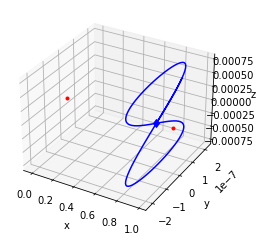

In [23]:
#print(newt.s)
s_opt = newt.s[-1,:]
pz = pn.pz_finder(s_opt,E,m)
r_opt = np.array([s_opt[0],s_opt[1],0,s_opt[2],s_opt[3],pz])
sol = solve_ivp(ph.ham_eqs,[0,3],r_opt,args=(m,),atol=1e-12,rtol=1e-11)
fig = plt.figure(1)
ax1 = plt.axes(projection='3d')
ax1.plot(sol.y[0,:],sol.y[1,:],sol.y[2,:],'b')
ax1.plot(sol.y[0,0],sol.y[1,0],sol.y[2,0],'db')
ax1.plot(1-m,0,0,'.r')
ax1.plot(-m,0,0,'.r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
plt.show()

## 6. Tube manifolds

Now we are interested in the linear properties of the Poincarè map around the fixed point. We need the Jacobian for the fixed point and its eigenvalues and eigenvectors.

In [24]:
M = pn.pJacob(s_opt,E,m)

MD,MV = np.linalg.eig(M)
print(MD)

[3.36053280e+03+0.j         2.90826615e-04+0.j
 9.83503696e-01+0.18057214j 9.83503696e-01-0.18057214j]


We notice that the first and second eigenvalue have null imaginary part and that the eigenvalues $|\rho_1|>1$ , $|\rho_2|<1$, therefore their respective eigenvectors span the unstable and stable linear spaces of the Poincaré map.
Points from these spaces will translate respectively to the unstable and stable tube manifolds in the original phase space.

We calculate the trajectories originating from a few of these points to visualize the manifolds.

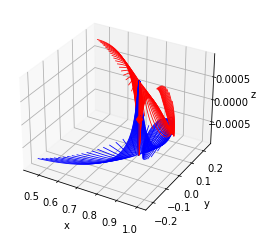

In [25]:
fig = plt.figure(2)
ax2 = plt.axes(projection='3d')
for i in range(-20,20):
    uU = i*1e-6*np.array([1,0,0,0])
    uS = i*1e-6*np.array([0,1,0,0])
    sU = s_opt + np.real(MV@uU)
    sS = s_opt + np.real(MV@uS)
    pU = pn.pz_finder(sU,E,m)
    pS = pn.pz_finder(sS,E,m)
    rU = np.array([sU[0],sU[1],0,sU[2],sU[3],pU])
    rS = np.array([sS[0],sS[1],0,sS[2],sS[3],pS])
    
    solS = solve_ivp(ph.ham_eqs,[0,-4],rS,args=(m,),atol=1e-12,rtol=1e-11)
    solU = solve_ivp(ph.ham_eqs,[0,4],rU,args=(m,),atol=1e-12,rtol=1e-11)
    
    ax2.plot(solS.y[0,:],solS.y[1,:],solS.y[2,:],'b',linewidth=.8)
    ax2.plot(solS.y[0,0],solS.y[1,0],solS.y[2,0],'db')
    ax2.plot(solU.y[0,:],solU.y[1,:],solU.y[2,:],'r',linewidth=.8)
    ax2.plot(solU.y[0,0],solU.y[1,0],solU.y[2,0],'dr')
    
ax2.plot(1-m,0,0,'.r')
#ax2.plot(-m,0,0,'.r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
plt.show()